In [2]:
import xarray as xr
import cftime # type: ignore
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
from datetime import datetime
import seaborn as sns

In [53]:
# Function to calculate the number of hours in each month
def hours_in_month(year, month):
    if month == 12:
        next_month = datetime(year + 1, 1, 1)
    else:
        next_month = datetime(year, month + 1, 1)
    current_month = datetime(year, month, 1)
    delta = next_month - current_month
    return delta.days * 24

# Directory containing the NetCDF files
directory = "C:\\Users\\DELL\\Desktop\\ms-projects\\data"
file_path = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.nc4')]

# Open the dataset with decode_times=False
ds = xr.open_mfdataset(file_path, decode_times=False, combine='nested', concat_dim='time', chunks={})

# Manually decode the time using cftime
time_var = ds['time']
times = cftime.num2date(time_var.values, time_var.units, calendar=time_var.attrs.get('calendar', 'standard'))
times = pd.to_datetime([t.strftime('%Y-%m-%d %H:%M:%S') for t in times])

# Assign the converted times back to the dataset
ds['time'] = ('time', times)

# Calculate total monthly precipitation
precipitation = ds['precipitation'].copy()

# Loop over each time step to multiply by the number of hours in each month
for t in range(len(ds['time'])):
    date = pd.Timestamp(ds['time'].values[t])
    year = date.year
    month = date.month
    hours = hours_in_month(year, month)
    precipitation[t, :, :] *= hours

# Update the precipitation data and units in the dataset
ds['precipitation'] = precipitation
ds['precipitation'].attrs['units'] = 'mm'

# Filter the dataset for the time period from 2010 to 2023
ds_filtered = ds.sel(time=slice('2010-01-01', '2023-12-31'))

# Save the processed data to a new NetCDF file
output_filename = 'combined.nc'
ds_filtered.to_netcdf(output_filename)

print(f"Processed data has been saved to {output_filename}")

Processed data has been saved to combined.nc


In [3]:
combine_data = xr.open_dataset('combined.nc')
combine_data = combine_data.sel(time=slice('2010','2023'))
kumasi = combine_data.sel(lat=6.72,lon=-1.6, method='nearest')

c:\Users\DELL\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [4]:
annual_rainfall_totals = kumasi['precipitation'].resample(time='1Y').sum().groupby('time.year').mean()
monthly_precip = kumasi['precipitation'].resample(time='1M').sum().groupby('time.month').mean()
bimodal_pattern = monthly_precip.to_dataframe(name=None, dim_order=None)
bimodal_pattern = np.array(bimodal_pattern.precipitation)


Text(0.5, 1.0, 'Monthly Rainfall Climatology')

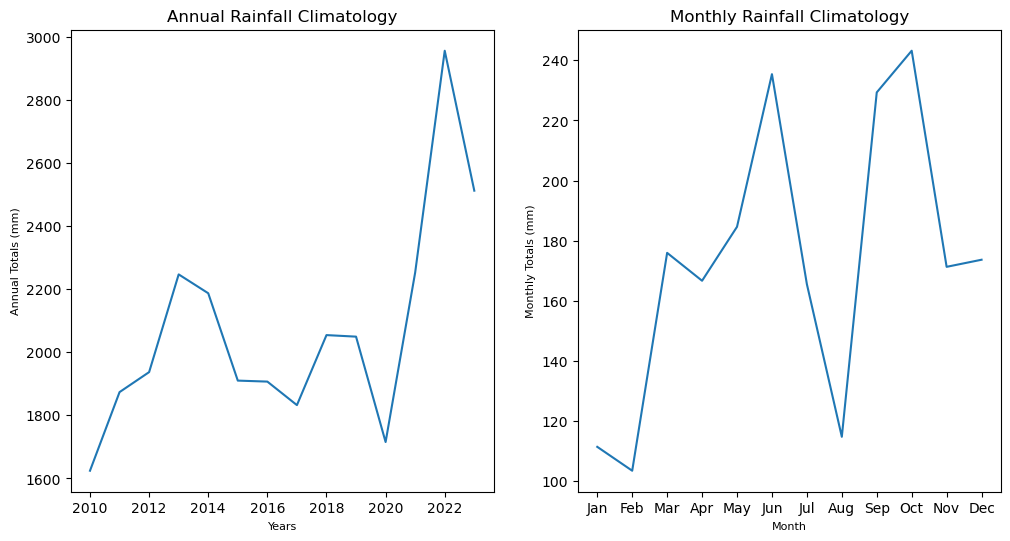

In [5]:

fig,ax =plt.subplots(1,2, figsize=(12,6))
year = ['2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020','2021','2022','2023']
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug','Sep', 'Oct', 'Nov', 'Dec']
ax[0].plot(annual_rainfall_totals.year, annual_rainfall_totals, label='Annual Rainfall Climatoloy')

ax[0].set_xlabel('Years', fontsize=8)
ax[0].set_ylabel('Annual Totals (mm)', fontsize=8)
ax[0].set_title('Annual Rainfall Climatology')

ax[1].plot(months, bimodal_pattern, label='Monthly Rainfall Climatology')
ax[1].set_xlabel('Month', fontsize=8)
ax[1].set_ylabel('Monthly Totals (mm)',fontsize=8)
ax[1].set_title('Monthly Rainfall Climatology')


Text(0.5, 1.0, 'Monthly Rainfall Climatology')

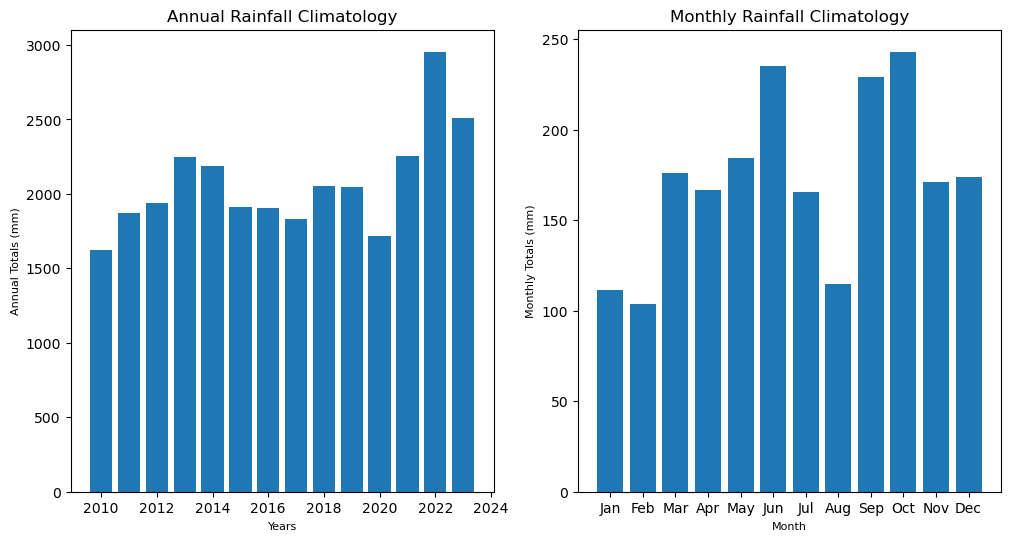

In [6]:

fig,ax =plt.subplots(1,2, figsize=(12,6))
year = ['2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020','2021','2022','2023']
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug','Sep', 'Oct', 'Nov', 'Dec']
ax[0].bar(annual_rainfall_totals.year, annual_rainfall_totals, label='Annual Rainfall Climatoloy')

ax[0].set_xlabel('Years', fontsize=8)
ax[0].set_ylabel('Annual Totals (mm)', fontsize=8)
ax[0].set_title('Annual Rainfall Climatology')

ax[1].bar(months, bimodal_pattern, label='Monthly Rainfall Climatology')
ax[1].set_xlabel('Month', fontsize=8)
ax[1].set_ylabel('Monthly Totals (mm)',fontsize=8)
ax[1].set_title('Monthly Rainfall Climatology')

In [23]:
threshold_m = monthly_precip.quantile(0.90)
threshold_y = annual_rainfall_totals.quantile(0.90)
high_impact_years= annual_rainfall_totals[annual_rainfall_totals >= threshold_y]
high_impact_months = monthly_precip[monthly_precip >= threshold_m]
threshold_m.values


array(234.78171082)

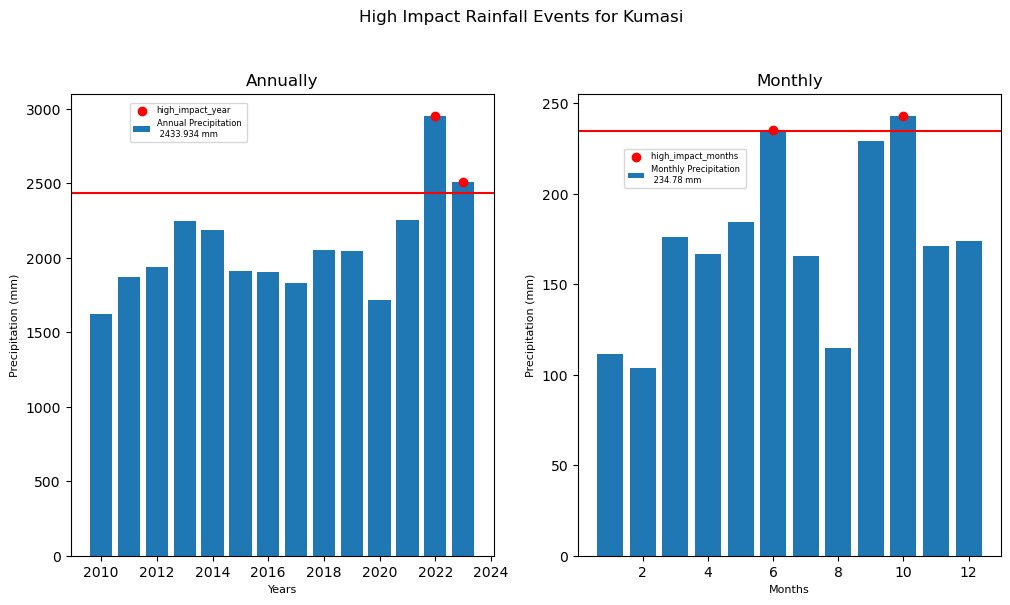

In [33]:

fig,ax =plt.subplots(1,2, figsize=(12,6))
ax[0].bar(annual_rainfall_totals['year'], annual_rainfall_totals, label=f"Annual Precipitation \n {threshold_y.values:.3f} mm")
ax[0].scatter(high_impact_years['year'], high_impact_years, color='red', label=f"high_impact_year")
ax[0].axhline(threshold_y, color='r')
ax[0].set_xlabel('Years', fontsize=8)
ax[0].set_ylabel('Precipitation (mm)', fontsize=8)
ax[0].set_title('Annually')
ax[0].legend(loc =2, bbox_to_anchor=(0.13, 0.99), fontsize = 6)

ax[1].bar(monthly_precip['month'], monthly_precip, label=f"Monthly Precipitation \n {threshold_m.values:.2f} mm")
ax[1].scatter(high_impact_months['month'], high_impact_months, color='red', label=f'high_impact_months ')
ax[1].axhline(threshold_m, color='r')

ax[1].set_xlabel('Months', fontsize=8)
ax[1].set_ylabel('Precipitation (mm)',fontsize=8)
ax[1].set_title('Monthly')
ax[1].legend(loc =2, bbox_to_anchor=(0.10, 0.89), fontsize = 6)

plt.suptitle('High Impact Rainfall Events for Kumasi', y=1.02)



plt.show()
#monthly_precip['month']

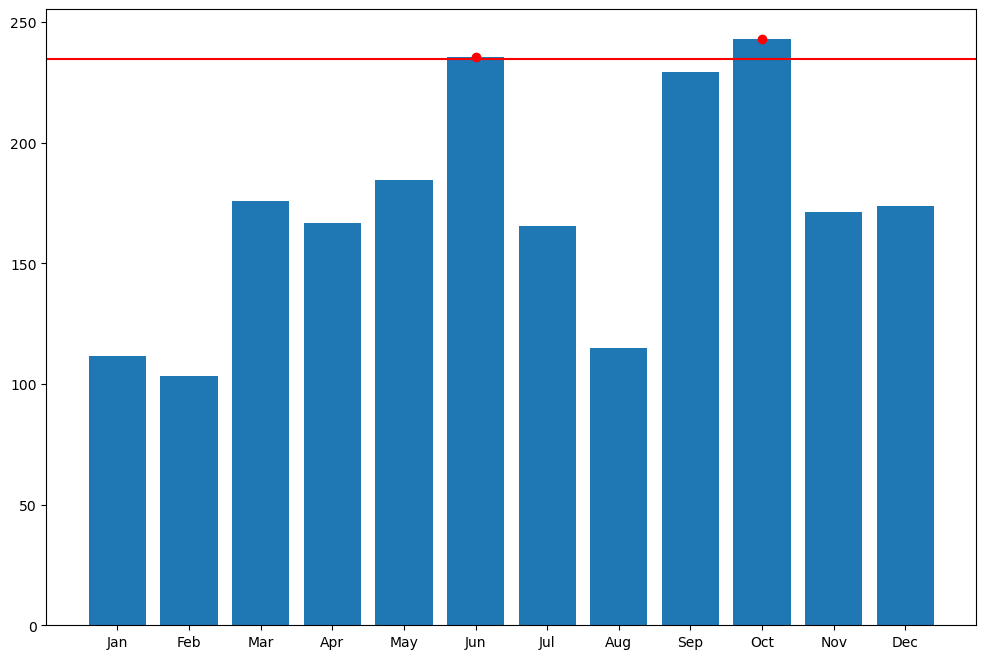

In [51]:
threshold = monthly_precip.quantile(0.90)

high_impact_months = monthly_precip[monthly_precip >= threshold]

plt.figure(figsize=(12,8))

plt.bar(monthly_precip['month'], monthly_precip, label='Monthly Precipitation')
plt.scatter(high_impact_months['month'], high_impact_months, color='red', label='high_impact_months')
plt.axhline(threshold, color='r')

plt.show()
#monthly_precip['month']

In [ ]:

monthly_precip = kumasi['precipitation'].resample(time='1M').sum().groupby('time.month').mean()
monthly_precip

In [ ]:
monthly_precip_df = monthly_precip.to_dataframe().reset_index()
monthly_precip_df

In [ ]:
#bimodal_pattern = monthly_precip.mean(dim=('lon','lat'))

In [ ]:
bimodal_pattern = monthly_precip.to_dataframe(name=None, dim_order=None)
bimodal_pattern = np.array(bimodal_pattern.precipitation)

In [ ]:
plt.figure(figsize=(8, 6))
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug','Sep', 'Oct', 'Nov', 'Dec']
plt.xlabel('Months')
plt.ylabel("rainfall (mm)")
plt.suptitle('Bimodal rainfall pattern from 2010 - 2023')
plt.plot(months, bimodal_pattern,label='Bimodal Pattern')



In [ ]:
threshold = monthly_precip_df['precipitation'].quantile(0.90)

high_impact_months = monthly_precip_df[monthly_precip_df['precipitation'] >= threshold]

In [ ]:
print(high_impact_months)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
plt.plot(monthly_precip_df['time'], monthly_precip_df['precipitation'], label='Monthly Precipitation')
plt.scatter(high_impact_months['time'], high_impact_months['precipitation'], color='red', label='high_impact_months')

plt.show()